<a href="https://colab.research.google.com/github/AudreyyFortune/kaggle/blob/main/KaggleNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJET KAGGLE 
## OpenVaccine : Prévision de la dégradation de l’ARNm du vaccin contre la COVID-19


## Modules importation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#File import
from google.colab import files
import io

#Ski-learn
from sklearn.model_selection import StratifiedKFold, GroupKFold

#Tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import tensorflow_addons
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout

In [ ]:
#Check if the GPU is found
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Fix seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

## File import

In [ ]:
#Upload the data files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [ ]:
train_data = pd.read_json("train.json", lines = True).drop('index' , axis = 1)
test_data = pd.read_json("test.json", lines = True).drop('index' , axis = 1)
sample_df = pd.read_csv("sample_submission.csv")

In [ ]:
train_data.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:
test_data.head()

,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [ ]:
sample_df.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Train dataset shape:", train_data.shape)
print("Filtered train dataset shape:", train_data.query("SN_filter == 1").shape)
print("Not filtered train dataset shape:", train_data.query("SN_filter == 0").shape)
print("")
print("Test dataset shape:", test_data.shape)
print("Test 107 bp dataset shape:",test_data.query("seq_length == 107").shape)
print("Test 130 bp dataset shape:",test_data.query("seq_length == 130").shape)

Train dataset shape: (2400, 18)
Filtered train dataset shape: (1589, 18)
Not filtered train dataset shape: (811, 18)

Test dataset shape: (3634, 6)
Test 107 bp dataset shape: (629, 6)
Test 130 bp dataset shape: (3005, 6)


## Creates class weights

### Create Fasta files with sequences for external analysis

In [ ]:
#Fasta file with filtered train sequence to compute cluster based on sequence identity
train_id = train_data.query("SN_filter == 1")["id"]
train_seq = train_data.query("SN_filter == 1")["sequence"]

with open('train107.fasta', 'w') as f:
    for id, seq in zip(train_id, train_seq):
        f.write(f'>{id}\n')
        f.write(f'{seq}\n')

files.download('train107.fasta')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Fasta file with 107 pb test sequences to compute clusters based on sequencce identity

test_id = test_data.query("seq_length == 107")["id"]
test_seq = test_data.query("seq_length == 107")["sequence"]

with open('sequencestest107.fasta', 'w') as f:
    for id, seq in zip(test_id, test_seq):
        f.write(f'>{id}\n')
        f.write(f'{seq}\n')

files.download('sequencestest107.fasta')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Fasta file with 130 pb test sequences to compute clusters based on sequencce identity

test_id = test_data.query("seq_length == 130")["id"]
test_seq = test_data.query("seq_length == 130")["sequence"]

with open('sequencestest130.fasta', 'w') as f:
    for id, seq in zip(test_id, test_seq):
        f.write(f'>{id}\n')
        f.write(f'{seq}\n')

files.download('sequencestest130.fasta')

## Read the file and create class weights

In [ ]:
#Upload the data files
cluster_file = files.upload()

Saving train_cluster.txt to train_cluster.txt


In [ ]:
dico_cluster = {}

with open("train_cluster.txt") as f_in:
  for line in f_in:
    if line.startswith(">"):
      id_cluster = int(line.split()[1])
      dico_cluster[id_cluster] = []
    else:
      id_seq = line.split()[2][1:-3]
      dico_cluster[id_cluster].append(id_seq)

print(dico_cluster[0])

['id_006f36f57', 'id_1abf939e4', 'id_1b072023e', 'id_1e833c670', 'id_1e8eae443', 'id_20520d1bd', 'id_26843a332', 'id_3010f9cac', 'id_3f8c56752', 'id_3fa7f0df7', 'id_468a56589', 'id_4818bfd8f', 'id_55a97fe18', 'id_55ecdae7b', 'id_586997629', 'id_5c7ae0123', 'id_62b6318b4', 'id_80082199f', 'id_85c22c0a3', 'id_953f8ceb9', 'id_ab441d871', 'id_b2d813595', 'id_b664e8e0a', 'id_c725ed0e9', 'id_c9c063a89', 'id_d0da7b69a', 'id_f11efec6d', 'id_f1c2edeac', 'id_f2f764461', 'id_fcdf5eda3']


In [ ]:
sample_weight = train_data.query("SN_filter == 1")["id"].to_numpy()

for cluster_key in dico_cluster:
  for id_cluster in dico_cluster[cluster_key]:
    sample_weight[sample_weight == id_cluster] = 1 / np.sqrt(len(dico_cluster[cluster_key]))
    #sample_weight[sample_weight == id_cluster] = 1 / len(dico_cluster[cluster_key])

sample_weight = np.asarray(sample_weight).astype(np.float32)
sample_weight

array([0.5       , 0.18257418, 0.70710677, ..., 0.57735026, 0.24253562,
       1.        ], dtype=float32)

## Data encoding

In [ ]:
#Select only the high quality data (filtered)
train_data = train_data[train_data["SN_filter"] == 1]

In [ ]:
X_train = train_data[["sequence", "structure", "predicted_loop_type"]]
Y_train = train_data[["reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"]]

### X train one-hot encoding

In [ ]:
arn2int = {x:i for i, x in enumerate("ACGU")}
X_train_seq = X_train["sequence"].apply(lambda seq: [arn2int[x] for x in seq])
X_train_seq = np.array(X_train_seq.values.tolist())
X_train_seq_cat = to_categorical(X_train_seq, 4)

struct2int = {x:i for i, x in enumerate(".()")}
X_train_struct = X_train["structure"].apply(lambda seq: [struct2int[x] for x in seq])
X_train_struct = np.array(X_train_struct.values.tolist())
X_train_struct_cat = to_categorical(X_train_struct, 3)

loop2int = {x:i for i, x in enumerate("BEHIMSX")}
X_train_loop = X_train["predicted_loop_type"].apply(lambda seq: [loop2int[x] for x in seq])
X_train_loop = np.array(X_train_loop.values.tolist())
X_train_loop_cat = to_categorical(X_train_loop, 7)

X_train = np.concatenate((X_train_seq_cat, X_train_struct_cat, X_train_loop_cat), axis=2)

In [ ]:
#Selection of the 68 first bases
X_train = X_train[:,:68,:]

### Y train preparation

In [ ]:
Y_train_reactivity =  np.array(Y_train["reactivity"].values.tolist())
Y_train_deg_Mg_pH10 =  np.array(Y_train["deg_Mg_pH10"].values.tolist())
Y_train_deg_Mg_50C =  np.array(Y_train["deg_Mg_50C"].values.tolist())
Y_train_deg_pH10 =  np.array(Y_train["deg_pH10"].values.tolist())
Y_train_deg_50C =  np.array(Y_train["deg_50C"].values.tolist())

Y_train =  np.stack([Y_train_reactivity, Y_train_deg_Mg_pH10, Y_train_deg_Mg_50C, Y_train_deg_pH10, Y_train_deg_50C], axis = 2)

## Models evaluation in 10-fold Cross-Validation

In [ ]:
#Chose the data you want to predict
#Y_train =  np.stack([Y_train_reactivity], axis = 2)
#Y_train =  np.stack([Y_train_reactivity, Y_train_deg_Mg_pH10, Y_train_deg_Mg_50C], axis = 2)
Y_train =  np.stack([Y_train_reactivity, Y_train_deg_Mg_pH10, Y_train_deg_Mg_50C, Y_train_deg_pH10, Y_train_deg_50C], axis = 2)

nb = Y_train.shape[2]

In [ ]:
#Create the competition evaluation metric : MCRMSE

from keras import backend as K

def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def MCRMSE(y_actual, y_pred, num_scored=nb):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

### Dense model

In [ ]:
# DENSE

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CV_pred = np.array([]).reshape(0,68,nb)
scores_mse = []
scores_mcrmse = []

for train, test in kfold.split(np.zeros((X_train.shape[0], 1)), np.zeros((X_train.shape[0], 1))):

    model1 = Sequential()
    model1.add(Dense(128, input_shape=(68, 14), activation='softmax'))
    model1.add(Dense(64, activation="softmax"))
    model1.add(Dense(32, activation="softmax"))
    model1.add(Dense(nb, activation='linear'))

    model1.compile(loss = "mse",
                   optimizer="adam", 
                   metrics = [MCRMSE])

    callbacks_list = [
        EarlyStopping(monitor="val_loss", 
                      patience=10),
        ReduceLROnPlateau(patience=5)]
    
    plot_model(model1, "model1.png", show_shapes=True)
    H = model1.fit(x=X_train[train],
                  y=Y_train[train],
                  batch_size=64,
                  epochs=500,
                  callbacks=callbacks_list,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=0)
  
    pred = model1.predict(X_train[test], verbose=0)
    CV_pred = np.concatenate((CV_pred, pred), axis=0)
    scores = model1.evaluate(X_train[test], Y_train[test], verbose=0)
    
    print(f"{model1.metrics_names[0]}: {scores[0]:.4f}")
    scores_mse.append(scores[0])
    print(f"{model1.metrics_names[1]}: {scores[1]:.4f}")
    scores_mcrmse.append(scores[1])


print(f"MSE: {np.mean(scores_mse):.4f} (+/- {np.std(scores_mse):.4f})")
print(f"MCRMSE: {np.mean(scores_mcrmse):.4f} (+/- {np.std(scores_mcrmse):.4f})")

loss: 0.2440
MCRMSE: 0.4756
loss: 0.2400
MCRMSE: 0.4723
loss: 0.2468
MCRMSE: 0.4786
loss: 0.2394
MCRMSE: 0.4718
loss: 0.2345
MCRMSE: 0.4659
loss: 0.2559
MCRMSE: 0.4879
loss: 0.2568
MCRMSE: 0.4901
loss: 0.2500
MCRMSE: 0.4834
loss: 0.2427
MCRMSE: 0.4757
loss: 0.2289
MCRMSE: 0.4627
MSE: 0.2439 (+/- 0.0084)
MCRMSE: 0.4764 (+/- 0.0084)


### Conv1D+Dense

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CV_pred = np.array([]).reshape(0,68,nb)
scores_mse = []
scores_mcrmse = []

for train, test in kfold.split(np.zeros((X_train.shape[0], 1)), np.zeros((X_train.shape[0], 1))):

    model2 = Sequential()
    model2.add(Conv1D(filters=100, kernel_size=1, input_shape = (68, 14), padding="same", activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Conv1D(filters=125, kernel_size=3, padding="same", activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Conv1D(filters=150, kernel_size=5, padding="same", activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(128, activation="softmax"))
    model2.add(Dense(64, activation="softmax"))
    model2.add(Dense(32, activation="softmax"))
    model2.add(Dense(nb, activation="linear"))

    model2.compile(loss = "mse",
                   optimizer="adam", 
                   metrics = [MCRMSE])

    callbacks_list = [
        EarlyStopping(monitor="val_loss", 
                      patience=10),
        ReduceLROnPlateau(patience=5)]

    plot_model(model2, "model2.png", show_shapes=True)
    H = model2.fit(x=X_train[train],
                  y=Y_train[train],
                  batch_size=64,
                  epochs=500,
                  callbacks=callbacks_list,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=0)
  
    pred = model2.predict(X_train[test], verbose=0)
    CV_pred = np.concatenate((CV_pred, pred), axis=0)
    scores = model2.evaluate(X_train[test], Y_train[test], verbose=0)
    
    print(f"{model2.metrics_names[0]}: {scores[0]:.4f}")
    scores_mse.append(scores[0])
    print(f"{model2.metrics_names[1]}: {scores[1]:.4f}")
    scores_mcrmse.append(scores[1])


print(f"MSE: {np.mean(scores_mse):.4f} (+/- {np.std(scores_mse):.4f})")
print(f"MCRMSE: {np.mean(scores_mcrmse):.4f} (+/- {np.std(scores_mcrmse):.4f})")

loss: 0.2441
MCRMSE: 0.4756
loss: 0.2401
MCRMSE: 0.4723
loss: 0.2468
MCRMSE: 0.4787
loss: 0.2396
MCRMSE: 0.4719
loss: 0.2345
MCRMSE: 0.4659
loss: 0.2560
MCRMSE: 0.4879
loss: 0.2568
MCRMSE: 0.4901
loss: 0.1020
MCRMSE: 0.3066
loss: 0.2428
MCRMSE: 0.4757
loss: 0.2290
MCRMSE: 0.4628
MSE: 0.2292 (+/- 0.0432)
MCRMSE: 0.4588 (+/- 0.0514)


### GRU

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CV_pred = np.array([]).reshape(0,68,nb)
scores_mse = []
scores_mcrmse = []

for train, test in kfold.split(np.zeros((X_train.shape[0], 1)), np.zeros((X_train.shape[0], 1))):

    model3 = Sequential()
    model3.add(tf.keras.Input(shape = (68, 14)))
    model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model3.add(tf.keras.layers.TimeDistributed(Dense(nb, activation="linear")))

    model3.compile(loss = "mse",
                   optimizer="adam", 
                   metrics = [MCRMSE])

    callbacks_list = [
        EarlyStopping(monitor="val_loss", 
                      patience=10),
        ReduceLROnPlateau(patience=5)]
    plot_model(model3, "model3.png", show_shapes=True)

    H = model3.fit(x=X_train[train],
                  y=Y_train[train],
                  batch_size=64,
                  epochs=500,
                  callbacks=callbacks_list,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=0)
  
    pred = model3.predict(X_train[test], verbose=0)
    CV_pred = np.concatenate((CV_pred, pred), axis=0)
    scores = model3.evaluate(X_train[test], Y_train[test], verbose=0)
    
    print(f"{model3.metrics_names[0]}: {scores[0]:.4f}")
    scores_mse.append(scores[0])
    print(f"{model3.metrics_names[1]}: {scores[1]:.4f}")
    scores_mcrmse.append(scores[1])


print(f"MSE: {np.mean(scores_mse):.4f} (+/- {np.std(scores_mse):.4f})")
print(f"MCRMSE: {np.mean(scores_mcrmse):.4f} (+/- {np.std(scores_mcrmse):.4f})")

loss: 0.0606
MCRMSE: 0.2285
loss: 0.0574
MCRMSE: 0.2261
loss: 0.0618
MCRMSE: 0.2315
loss: 0.0650
MCRMSE: 0.2373
loss: 0.0629
MCRMSE: 0.2334
loss: 0.0609
MCRMSE: 0.2280
loss: 0.0648
MCRMSE: 0.2387
loss: 0.0571
MCRMSE: 0.2262
loss: 0.0555
MCRMSE: 0.2214
loss: 0.0545
MCRMSE: 0.2214
MSE: 0.0601 (+/- 0.0035)
MCRMSE: 0.2293 (+/- 0.0056)


### GRU+Conv1D

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CV_pred = np.array([]).reshape(0,68,nb)
scores_mse = []
scores_mcrmse = []
H_save = []

for train, test in kfold.split(np.zeros((X_train.shape[0], 1)), np.zeros((X_train.shape[0], 1))):

    model4 = Sequential()
    model4.add(Conv1D(filters=64, kernel_size=3, input_shape = (68, 14), padding="same", activation = "relu"))
    model4.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model4.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model4.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
    model4.add(tf.keras.layers.TimeDistributed(Dense(nb, activation="linear")))

    model4.compile(loss = "mse",
                   optimizer="adam", 
                   metrics = [MCRMSE])

    callbacks_list = [
        EarlyStopping(monitor="val_loss", 
                      patience=10),
        ReduceLROnPlateau(patience=5)]

    plot_model(model4, "model4.png", show_shapes=True)
    H = model4.fit(x=X_train[train],
                  y=Y_train[train],
                  batch_size=64,
                  epochs=500,
                  callbacks=callbacks_list,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=0)

    H_save.append(H)

    pred = model4.predict(X_train[test], verbose=0)
    CV_pred = np.concatenate((CV_pred, pred), axis=0)
    scores = model4.evaluate(X_train[test], Y_train[test], verbose=0)
    
    print(f"{model4.metrics_names[0]}: {scores[0]:.4f}")
    scores_mse.append(scores[0])
    print(f"{model4.metrics_names[1]}: {scores[1]:.4f}")
    scores_mcrmse.append(scores[1])


print(f"MSE: {np.mean(scores_mse):.4f} (+/- {np.std(scores_mse):.4f})")
print(f"MCRMSE: {np.mean(scores_mcrmse):.4f} (+/- {np.std(scores_mcrmse):.4f})")

loss: 0.0569
MCRMSE: 0.2215
loss: 0.0556
MCRMSE: 0.2217
loss: 0.0606
MCRMSE: 0.2297
loss: 0.0572
MCRMSE: 0.2200
loss: 0.0577
MCRMSE: 0.2209
loss: 0.0595
MCRMSE: 0.2266
loss: 0.0608
MCRMSE: 0.2303
loss: 0.0564
MCRMSE: 0.2247
loss: 0.0549
MCRMSE: 0.2191
loss: 0.0536
MCRMSE: 0.2191
MSE: 0.0573 (+/- 0.0023)
MCRMSE: 0.2234 (+/- 0.0040)


## Evaluation of the best model - GRU + Conv1D

In [ ]:
#Graphicals parameters
sns.set("notebook",  style="darkgrid", palette="bright", font_scale = 1.5 , rc = {"lines.linewidth": 2.5})
c_palette = sns.color_palette("bright", 10)

### Plot of the CV metrics

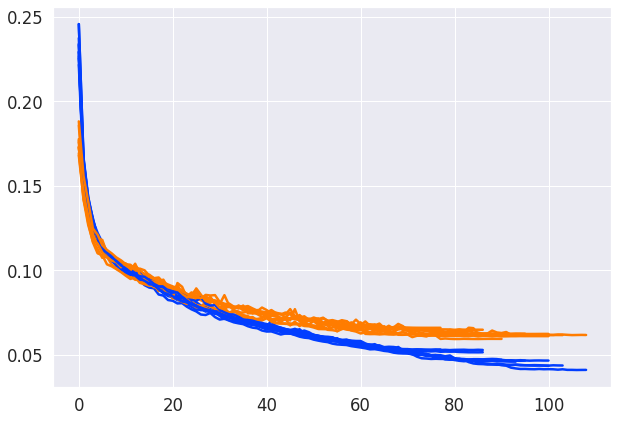

In [ ]:
plt.figure(figsize=(10,7))

for H in H_save:
  plt.plot(H.history["loss"], color=c_palette[0]);
  plt.plot(H.history["val_loss"], color=c_palette[1]);

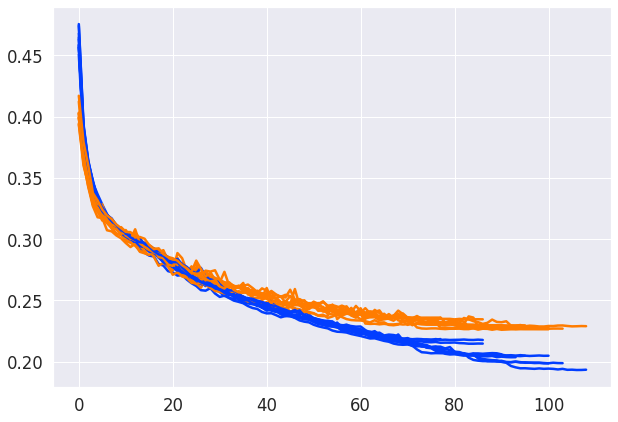

In [ ]:
plt.figure(figsize=(10,7))

for H in H_save:
  plt.plot(H.history["MCRMSE"], color=c_palette[0]);
  plt.plot(H.history["val_MCRMSE"], color=c_palette[1]);

### Plot of the predicted Y values against true Y values

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


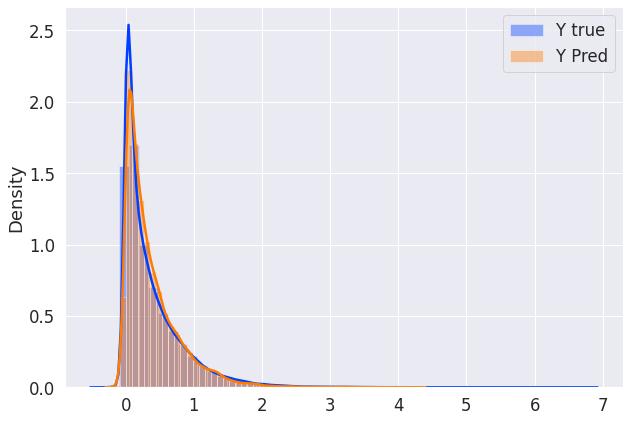

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(Y_train[:,:,0], label="Y true")
sns.distplot(CV_pred[:,:,0], label="Y Pred")
plt.legend();

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


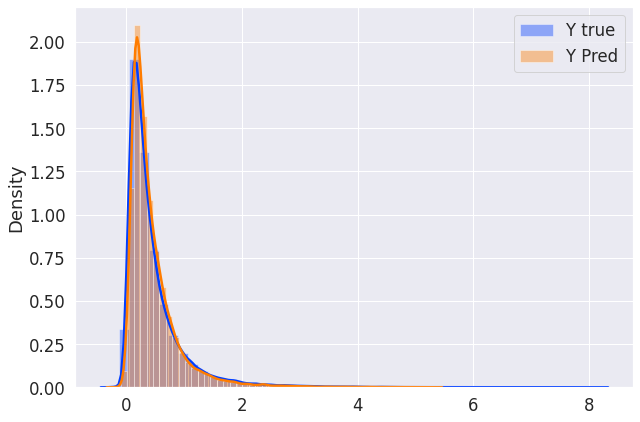

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(Y_train[:,:,1], label="Y true")
sns.distplot(CV_pred[:,:,1], label="Y Pred")
plt.legend();

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


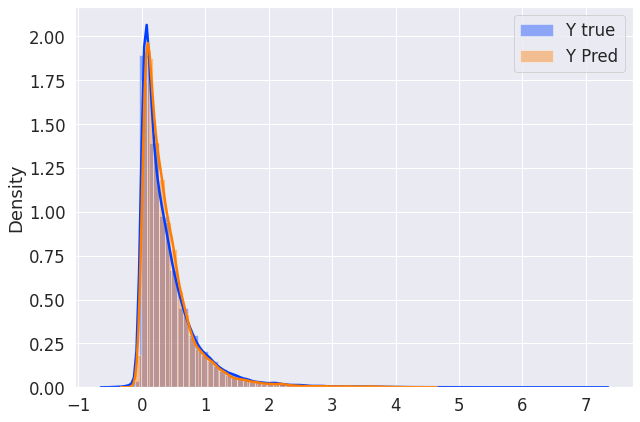

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(Y_train[:,:,2], label="Y true")
sns.distplot(CV_pred[:,:,2], label="Y Pred")
plt.legend();

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


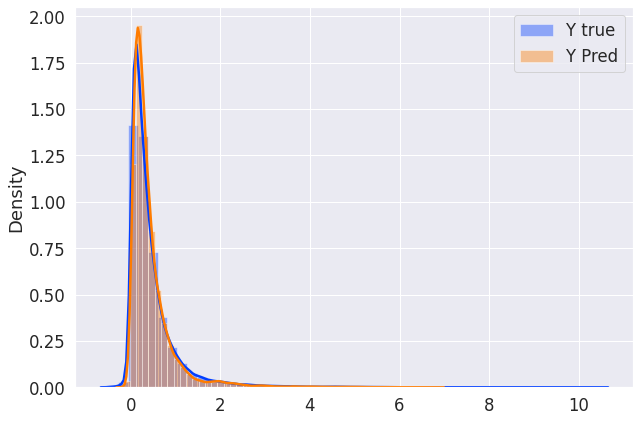

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(Y_train[:,:,3], label="Y true")
sns.distplot(CV_pred[:,:,3], label="Y Pred")
plt.legend();

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


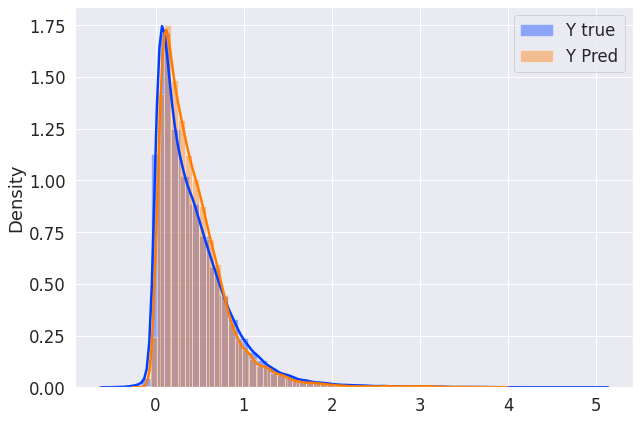

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(Y_train[:,:,4], label="Y true")
sns.distplot(CV_pred[:,:,4], label="Y Pred")
plt.legend();

## Train the best model with all the train data

In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, input_shape = (68, 14), padding="same", activation = "relu"))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model.add(tf.keras.layers.TimeDistributed(Dense(5, activation="linear")))

model.compile(loss = "mse",
               optimizer="adam",
               metrics = [MCRMSE])

print(model.summary())
plot_model(model, "model.png", show_shapes=True)


callbacks_list = [
    EarlyStopping(monitor="val_loss", 
                  patience=10)]

H = model.fit(x=X_train,
              y=Y_train,
              batch_size=64,
              epochs=500,
              callbacks=callbacks_list,
              validation_split=0.1,
              #sample_weight = sample_weight,
              shuffle=True,
              verbose=1)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 68, 64)            2752      
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 68, 256)           148992    
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 68, 256)           296448    
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 68, 256)           296448    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 68, 5)             1285      
Total params: 745,925
Trainable params: 745,925
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
23/23 [==============================] - 2s 102ms/step - loss: 0.2159 - MCRMSE: 0.4451 - val_los

## Test this models with test data

### X test one-hot encoding

In [ ]:
X_test107 = test_data.query("seq_length == 107")
X_test130 = test_data.query("seq_length == 130")

#### Public dataset (107 bp)

In [ ]:
arn2int = {x:i for i, x in enumerate("ACGU")}
X_test107_seq = X_test107["sequence"].apply(lambda seq: [arn2int[x] for x in seq])
X_test107_seq = np.array(X_test107_seq.tolist())
X_test107_seq = to_categorical(X_test107_seq, 4)

struct2int = {x:i for i, x in enumerate(".()")}
X_test107_struct = X_test107["structure"].apply(lambda seq: [struct2int[x] for x in seq])
X_test107_struct = np.array(X_test107_struct.values.tolist())
X_test107_struct = to_categorical(X_test107_struct, 3)

loop2int = {x:i for i, x in enumerate("BEHIMSX")}
X_test107_loop = X_test107["predicted_loop_type"].apply(lambda seq: [loop2int[x] for x in seq])
X_test107_loop = np.array(X_test107_loop.values.tolist())
X_test107_loop = to_categorical(X_test107_loop, 7)

X_test107_all = np.concatenate((X_test107_seq, X_test107_struct, X_test107_loop), axis=2)

#### Private dataset (130 bp)

In [ ]:
arn2int = {x:i for i, x in enumerate("ACGU")}
X_test130_seq = X_test130["sequence"].apply(lambda seq: [arn2int[x] for x in seq])
X_test130_seq = np.array(X_test130_seq.tolist())
X_test130_seq = to_categorical(X_test130_seq, 4)

struct2int = {x:i for i, x in enumerate(".()")}
X_test130_struct = X_test130["structure"].apply(lambda seq: [struct2int[x] for x in seq])
X_test130_struct = np.array(X_test130_struct.values.tolist())
X_test130_struct = to_categorical(X_test130_struct, 3)

loop2int = {x:i for i, x in enumerate("BEHIMSX")}
X_test130_loop = X_test130["predicted_loop_type"].apply(lambda seq: [loop2int[x] for x in seq])
X_test130_loop = np.array(X_test130_loop.values.tolist())
X_test130_loop = to_categorical(X_test130_loop, 7)

X_test130_all = np.concatenate((X_test130_seq, X_test130_struct, X_test130_loop), axis=2)

### Transfer the weights of the model into new ones for predictions

#### Public data (107 bp)

In [ ]:
model107 = Sequential()

model107.add(Conv1D(filters=64, kernel_size=3, input_shape = (107, 14), padding="same", activation = "relu"))
model107.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model107.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model107.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model107.add(Dense(5, activation="linear"))

model107.compile(loss = "mse",
              optimizer="adam",
              metrics = [MCRMSE])

print(model107.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 107, 64)           2752      
_________________________________________________________________
bidirectional_66 (Bidirectio (None, 107, 256)          148992    
_________________________________________________________________
bidirectional_67 (Bidirectio (None, 107, 256)          296448    
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 107, 256)          296448    
_________________________________________________________________
dense_102 (Dense)            (None, 107, 5)            1285      
Total params: 745,925
Trainable params: 745,925
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model107.set_weights(model4.get_weights())

In [ ]:
Y_pred107 = model107.predict(X_test107_all)

#### Private data (130 bp)

In [ ]:
model130 = Sequential()

model130.add(Conv1D(filters=64, kernel_size=3, input_shape = (130, 14), padding="same", activation = "relu"))
model130.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model130.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model130.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True)))
model130.add(Dense(5, activation="linear"))

model130.compile(loss = "mse",
              optimizer="adam",
              metrics = [MCRMSE])

print(model130.summary())

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 130, 64)           2752      
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 130, 256)          148992    
_________________________________________________________________
bidirectional_70 (Bidirectio (None, 130, 256)          296448    
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 130, 256)          296448    
_________________________________________________________________
dense_103 (Dense)            (None, 130, 5)            1285      
Total params: 745,925
Trainable params: 745,925
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model130.set_weights(model4.get_weights())

In [ ]:
Y_pred130 = model130.predict(X_test130_all)

## Create CSV file for Kaggle submission

In [ ]:
pred_cols = ["reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"]

preds_ls = []

for df, preds in [(X_test107, Y_pred107), (X_test130, Y_pred130)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>